<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Zero_Shot_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INF6804 Vision par ordinateur

**Polytechnique Montréal**  
**Auteurs :** Xavier Chalifoux et François Marie 

**Description :** Ce notebook présente la comparaison entre différents modèles de segmentation : classes fixes (Yolo) et zero-shot (Clip).


#### 1. Imports

In [2]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import time
from dataclasses import dataclass
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import seaborn as sns
from tqdm import tqdm
from enum import Enum
import pandas as pd
import pickle
import itertools

#### 2. Fonctions et donneés partagées

In [3]:
# id des classes
PERSON_CLASS = 0
BACKPACK_CLASS = 24
CAR_CLASS = 2
DOG_CLASS = 16
CAT_CLASS = 15

# Dictionnaire des datasets, avec les classes à détecter pour YOLO
DATASETS = {
    "highway": ("data/baseline/highway", [CAR_CLASS]),
    "arctic_fox": ("data/baseline/arctic_fox", [PERSON_CLASS, DOG_CLASS, CAT_CLASS]),
    "pedestrians": ("data/baseline/pedestrians", [PERSON_CLASS]),
    "office": ("data/baseline/office", [PERSON_CLASS]),
    "office_occlusion": ("data/baseline/office_occlusion", [PERSON_CLASS]),
    "PETS2006": ("data/baseline/PETS2006", [PERSON_CLASS, BACKPACK_CLASS]),
}

# Dictionnaire des prompts pour chaque dataset pour CLIPSeg
PROMPTS = {
    "highway": ["car", "automobile", "a car or truck", "vehicle", "a car"],
    "arctic_fox": ["arctic fox", "white fox", "a fox", "an arctic fox", "fox"],
    "pedestrians": ["person", "a pedestrian", "pedestrian", "human", "a person"],
    "office": ["person", "a guy", "a person with a red shirt","human", "a person"],
    "office_occlusion": ["a person", "a man bust", "human", "head and chest", "a guy"],
    "PETS2006": ["person and backpack", "multiple person", "man carrying a bag", "a person or a backpack", "a person"],
}

# Type de modèle
class ModelType(Enum):
    YOLO = "YOLO"
    CLIPSEG = "CLIPSeg"

# Descripteur de modèle
@dataclass
class ModelDescriptor:
    name: str
    type: ModelType
    model: object
    processor: CLIPSegProcessor # Seulement pour CLIPSeg

# Génère et sauvegarde une vidéo à partir d'une liste d'images
def save_video(plot, video_name, fps=30):
        frame_size = (plot[0].shape[1], plot[0].shape[0])
        video = cv2.VideoWriter(f"./data/videos/{video_name}", cv2.VideoWriter_fourcc(*'DIVX'), fps, frame_size)
        for image in plot:
                video.write(image)
        video.release()

# Calcule l'intersection sur union entre deux masques binaires
def iou_performances(pred, target):
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Charge les noms des images d'un dossier dans l'ordre alphabétique
def read_folder(folder, start, end):
    return (sorted([f for f in os.listdir(folder) if f.lower().endswith(("png", "jpg", "jpeg"))]))[start:end]

# Sauvegarde un objet Python
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Charge un objet Python
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Ajuste les indices de début et de fin pour qu'ils soient dans la plage et sélectionne au moins min_images
def adjust_indices(folder, start, end, min_images=100, verbose=False):
    """Ensure start and end indices are within range and select at least min_images."""
    total_images = len([f for f in os.listdir(folder) if f.lower().endswith(("png", "jpg", "jpeg"))])

    if total_images == 0:
        raise ValueError(f"No images found in {folder}")

    end = min(end, total_images)
    if end - start < min_images:
        start = max(0, end - min_images)

    if verbose:
        print(f"📂 Adjusted indices for {folder}: Start = {start}, End = {end}, Total images = {total_images}")
    
    return start, end

# Plot les résultats des IoU en fonction des prompts pour chaque dataset
def plot_prompts_results(results):
    """Plots the IoU scores of all prompts for each dataset in a 3x2 grid of subplots, showing only relevant prompts but keeping all prompts in the legend."""
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12), sharey=True)
    axes = axes.flatten()  # Aplatir les axes pour faciliter l'indexation
    
    for ax, (dataset, prompts) in zip(axes, results.items()):
        dataset_names = []
        prompt_labels = []
        iou_scores = []

        for prompt, data in prompts.items():
            if data["avg_iou"] > 0:  # Ne garder que les prompts utilisés
                dataset_names.append(dataset)
                prompt_labels.append(prompt)
                iou_scores.append(data["avg_iou"])

        # Créer un DataFrame pour Seaborn
        df = pd.DataFrame({"Prompt": prompt_labels, "IoU Score": iou_scores})
        
        sns.barplot(data=df, x="Prompt", y="IoU Score", ax=ax, hue="Prompt", palette="viridis", alpha=0.8, legend=False)
        ax.set_title(f"{dataset}")
        ax.set_xlabel("Prompt")
        ax.set_ylabel("IoU Score")
        ax.set_xticks(range(len(prompt_labels)))  # Nombre fixe de ticks
        ax.set_xticklabels(prompt_labels, rotation=45, ha="right")
        ax.set_ylim(0, 1)  # Les valeurs d'IoU vont de 0 à 1

    # Ajouter une légende avec tous les prompts
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Prompt", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

# Plot les résultats des IoU pour chaque dataset pour chaque modèle
# Si plusieurs prompts ont été testés, celui avec le meilleur score IoU est sélectionné
# box_plot=True pour afficher un boxplot, sinon un barplot
def plot_model_compare(results:dict[str, dict], box_plot:bool=False, title=""):
    """Plots the IoU scores of all models for each dataset."""
    sns.set_style("whitegrid")

    dataset_names = []
    model_labels = []
    iou_scores = []

    if box_plot:
        for model_name, model_data in results.items():
            for dataset, data in model_data.items(): # Meilleure prompt sélectionnée
                iou_list = max(data.values(), key=lambda x: x["avg_iou"])["iou_scores"]
                dataset_names.extend([dataset]*len(iou_list))
                model_labels.extend([model_name]*len(iou_list))
                iou_scores.extend(iou_list)

    else:
        for model_name, model_data in results.items():
            for dataset, data in model_data.items():
                dataset_names.append(dataset)
                model_labels.append(model_name)
                # Get best average IoU score if multiple prompts were tested
                best = max(data.values(), key=lambda x: x["avg_iou"]) # Meilleure prompt sélectionnée
                iou_scores.append(best["avg_iou"])

    plt.figure(figsize=(12, 6))
    df = pd.DataFrame({"Dataset": dataset_names, "Model": model_labels, "IoU Score": iou_scores})

    if box_plot:
        sns.boxplot(data=df, x="Dataset", y="IoU Score", hue="Model", palette="viridis", showfliers=False)
    else:
        sns.barplot(data=df, x="Dataset", y="IoU Score", hue="Model", palette="viridis", alpha=0.8)

    plt.xlabel("Dataset")
    plt.ylabel("IoU Score")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)  # IoU de 0 à 1
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

# Plot les temps d'inférence pour chaque dataset pour chaque modèle
# Si plusieurs prompts ont été testés, celui avec le meilleur score IoU est sélectionné
def plot_time_compare(results:dict[str, dict], box_plot:bool=False, title=""):
    """Plots the time of all models for each dataset."""
    sns.set_style("whitegrid")

    dataset_names = []
    model_labels = []
    time_scores = []

    if box_plot:
        for model_name, model_data in results.items():
            for dataset, data in model_data.items():
                iou_list = max(data.values(), key=lambda x: x["avg_iou"])["times"] # Meilleure prompt sélectionnée
                dataset_names.extend([dataset]*len(iou_list))
                model_labels.extend([model_name]*len(iou_list))
                time_scores.extend(iou_list)

    else:
        for model_name, model_data in results.items():
            for dataset, data in model_data.items():
                dataset_names.append(dataset)
                model_labels.append(model_name)
                best = max(data.values(), key=lambda x: x["avg_iou"]) # Meilleure prompt sélectionnée
                time_scores.append(best["avg_time"])

    plt.figure(figsize=(12, 6))
    df = pd.DataFrame({"Dataset": dataset_names, "Model": model_labels, "Time": time_scores})
    if box_plot:
        sns.boxplot(data=df, x="Dataset", y="Time", hue="Model", palette="viridis", showfliers=False)
    else:
        sns.barplot(data=df, x="Dataset", y="Time", hue="Model", palette="viridis", alpha=0.8)

    plt.xlabel("Dataset")
    plt.ylabel("Temps (en s)")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.2)  # Temps de 0 à 1.2s
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

# Effectue l'inférence pour un modèle sur des datasets
# verbose=True pour afficher les résultats de chaque image, avec une image de test toutes les 10 images
# silent=True pour ne pas afficher les résultats
# Retourne un dict avec les résultats pour chaque dataset
def inference(dataset_names, model_descriptor:ModelDescriptor, start=900, end=1000, verbose=False, silent=False):
    """Tests multiple prompts per dataset and selects the best one based on IoU scores."""
    results = {}
    for dataset in dataset_names:
        data_path = DATASETS[dataset][0]
        classes = DATASETS[dataset][1]
        input_folder = os.path.join(data_path, "input")
        gt_folder = os.path.join(data_path, "groundtruth")

        # Ajuster les indices pour qu'ils soient dans la plage et sélectionner au moins 100 images
        start_indice, end_indice = adjust_indices(input_folder, start, end, 100, verbose)
        image_files = read_folder(input_folder, start_indice, end_indice)
        gt_files = read_folder(gt_folder, start_indice, end_indice)

        best_prompt = None
        best_iou = 0
        prompt_results = {}

        dataset_results = {}

        if not silent:
            print("=" * 120)
            print(f"📊 Evaluating Dataset: {dataset.upper()}")

        # Prompts pour chaque dataset
        prompts = PROMPTS[dataset]
        # Si YOLO, on n'utilise pas de prompts
        if model_descriptor.type == ModelType.YOLO:
            prompts =  [""]

        # Test de chaque prompt
        for prompt in prompts:
            iou_scores = []
            inference_times = []

            if prompt != "" and not silent:
                print(f"\n🔍 Testing Prompt: '{prompt}'")
            
            # Parcours des images
            for idx, (image_file, gt_file) in enumerate(tqdm(zip(image_files, gt_files), total=len(image_files), desc=f"Processing {dataset}"), start=1):
                image_path = os.path.join(input_folder, image_file)
                gt_path = os.path.join(gt_folder, gt_file)

                # Charger les images
                image = Image.open(image_path).convert("RGB")
                gt_image = Image.open(gt_path).convert("L")
                gt_mask = (np.array(gt_image) > 127).astype(np.uint8)  # Binarize

                # Démarrer le timer
                start_time = time.time()    
                           
                # Effectuer l'inférence en fonction du modèle et génération du masque binaire
                match model_descriptor.type:

                    case ModelType.YOLO:
                        outputs = model_descriptor.model(image, verbose=verbose, classes=classes)
                        if len(outputs) == 0 or outputs[0].masks is None: # Pas de détection (pas de masque)
                            mask_binary = np.zeros((image.size[1], image.size[0]))
                        else:
                            masks = outputs[0].masks
                            mask = np.zeros(masks.data[0].shape).astype(np.uint8)
                            for m in masks: # Fusionner les masques
                                m_binary = (m.data[0].numpy() > 0.5).astype(np.uint8)
                                mask |= m_binary
                            mask_binary = mask

                    case ModelType.CLIPSEG:
                        inputs = model_descriptor.processor(text=prompt, images=image, return_tensors="pt")
                        with torch.no_grad():
                            outputs = model_descriptor.model(**inputs)
                        pred_mask = outputs.logits.sigmoid().detach().cpu().numpy()[0]
                        mask_binary = (pred_mask > 0.5).astype(np.uint8)            

                # Stop timer
                inference_time = time.time() - start_time
                inference_times.append(inference_time)

                # Redimensionner le masque binaire à la taille de l'image originale
                mask_binary = cv2.resize(mask_binary, (gt_image.size[0], gt_image.size[1]), interpolation=cv2.INTER_NEAREST)

                # Calculer l'IoU
                iou_score = iou_performances(mask_binary, gt_mask)
                iou_scores.append(iou_score)

                # Afficher une image de test toutes les 10 images
                if verbose and idx % 10 == 0:
                    plt.figure(figsize=(18, 5))
                    plt.suptitle(f"Dataset: {dataset} | Prompt: '{prompt}'")

                    plt.subplot(1, 3, 1)
                    plt.imshow(image)
                    plt.title("Original Image")
                    plt.axis("off")

                    plt.subplot(1, 3, 2)
                    plt.imshow(mask_binary, cmap="gray")
                    plt.title("Predicted Mask")
                    plt.axis("off")

                    plt.subplot(1, 3, 3)
                    plt.imshow(gt_mask, cmap="gray")
                    plt.title("Ground Truth Mask")
                    plt.axis("off")

                    plt.show()

            # Calcul des statistiques
            avg_iou = np.mean(iou_scores)
            min_iou = np.min(iou_scores)
            max_iou = np.max(iou_scores)
            med_iou = np.median(iou_scores)
            std_iou = np.std(iou_scores)
            q1_iou = np.percentile(iou_scores, 25)
            q3_iou = np.percentile(iou_scores, 75)

            avg_time = np.mean(inference_times)
            med_time = np.median(inference_times)
            prompt_results[prompt] = avg_iou

            # Ajouter les résultats
            prompt_string = f"Prompt: '{prompt}' | " if prompt != "" else ""
            if not silent:
                print(f"✅ {prompt_string}Avg IoU: {avg_iou:.4f} | Avg Time: {avg_time:.4f}s/image")
                print("-" * 80)

            # Mettre à jour le meilleur IoU
            if avg_iou > best_iou:
                best_iou = avg_iou
                best_prompt = prompt

            # Sauvegarder les résultats pour chaque prompt
            dataset_results[prompt] = {
                "avg_iou": avg_iou,
                "iou_scores": iou_scores,  
                "min_iou": min_iou,
                "max_iou": max_iou,
                "med_iou": med_iou,
                "std_iou": std_iou,
                "q1_iou": q1_iou,
                "q3_iou": q3_iou,
                "avg_time": avg_time,
                "med_time": med_time,
                "times": inference_times,
            }

        # Afficher les résultats finaux
        if not silent:
            print("\n🏆 **Final Results for Dataset:**", dataset.upper())
            best_prompt_string = f"Best Prompt: '{best_prompt}' | " if best_prompt != "" else ""
            print(f"🔥 {best_prompt_string}Best IoU: {best_iou:.4f}\n")

        if best_prompt != "" and not silent:
            print("📊 **Full Results:**")
            
            # Tri des résultats par ordre décroissant
            sorted_results = sorted(prompt_results.items(), key=lambda x: x[1], reverse=True)
            for rank, (prompt, iou) in enumerate(sorted_results, start=1):
                print(f"  {rank}. '{prompt}' → IoU: {iou:.4f}")
            
            print("=" * 120, "\n")
        results[dataset] = dataset_results
    return results



        


#### 3. YOLO

##### 3.1. Chargement des modèles

In [11]:
yolo11n = YOLO("yolo11n-seg.pt")
yolo11s = YOLO("yolo11s-seg.pt")
yolo11m = YOLO("yolo11m-seg.pt")
yolo11l = YOLO("yolo11l-seg.pt")
yolo11x = YOLO("yolo11x-seg.pt")

##### 3.2. Génération des vidéos

In [ ]:
input_folder = "data/baseline"
videos = [("highway",30),
          ("office",30) ,
          ("pedestrians",30),
          ("PETS2006",30),
          ("arctic_fox",6)
          ]
model = yolo11n
for (video, fps) in videos:
    results = model(f"{input_folder}/{video}/input", stream=True)
    plot = [item.plot() for item in results]
    save_video(plot, f"yolo-{video}.avi", fps=fps)

##### 3.3. Performance

In [ ]:
dataset_list = ["highway"]
model = ModelDescriptor(name="Yolo11n" ,type=ModelType.YOLO, model=yolo11n, processor=None)
inference(dataset_list, model, verbose=False)

📊 Evaluating Dataset: HIGHWAY


Processing highway: 100%|██████████| 100/100 [00:08<00:00, 12.30it/s]

✅ Avg IoU: 0.7924 | Avg Time: 0.0792s/image
--------------------------------------------------------------------------------

🏆 **Final Results for Dataset:** HIGHWAY
🔥 Best IoU: 0.7924

📊 **Full Results:**
  1. '' → IoU: 0.7924



#### 4. CLIPSeg


##### 4.1. Chargement du modèle

In [33]:
clip_model_name = "CIDAS/clipseg-rd64-refined"
clip_processor = CLIPSegProcessor.from_pretrained(clip_model_name)
clip_model = CLIPSegForImageSegmentation.from_pretrained(clip_model_name)

##### 4.2. Performance

In [ ]:
dataset_list = ["highway"]
model_descriptor = ModelDescriptor(name="clipseg-rd64", type=ModelType.CLIPSEG, model=clip_model, processor=clip_processor)
inference(dataset_list, model_descriptor, verbose=False)

#### 5. Calcul des performances

In [ ]:
# Comparaison des modèles
all_results = {}
dataset_list = ["highway", "office", "office_occlusion", "pedestrians", "PETS2006", "arctic_fox"]

# YOLO
for model in [yolo11n, yolo11s, yolo11m, yolo11l, yolo11x]:
    name = model.model_name.removesuffix(".pt")
    model_descriptor = ModelDescriptor(name=name, type=ModelType.YOLO, model=model, processor=None)
    print(f"🔍 Evaluating Model: {name}")
    results = inference(dataset_list, model_descriptor, verbose=False, silent=True)
    all_results[name] = results

# CLIPSeg
clip_model_name = "CIDAS/clipseg-rd64-refined"
clip_processor = CLIPSegProcessor.from_pretrained(clip_model_name)
clip_model = CLIPSegForImageSegmentation.from_pretrained(clip_model_name)
model_descriptor = ModelDescriptor(name="clipseg-rd64", type=ModelType.CLIPSEG, model=clip_model, processor=clip_processor)
print(f"🔍 Evaluating Model: {clip_model_name}")
results = inference(dataset_list, model_descriptor, verbose=False, silent=True)
all_results[model_descriptor.name] = results


🔍 Evaluating Model: yolo11n-seg


Processing arctic_fox: 100%|██████████| 65/65 [00:04<00:00, 13.93it/s]


🔍 Evaluating Model: yolo11s-seg


Processing arctic_fox: 100%|██████████| 65/65 [00:09<00:00,  6.86it/s]


🔍 Evaluating Model: yolo11m-seg


Processing arctic_fox: 100%|██████████| 65/65 [00:24<00:00,  2.69it/s]


🔍 Evaluating Model: yolo11l-seg


Processing arctic_fox: 100%|██████████| 65/65 [00:27<00:00,  2.34it/s]


🔍 Evaluating Model: yolo11x-seg


Processing arctic_fox: 100%|██████████| 65/65 [00:52<00:00,  1.24it/s]


🔍 Evaluating Model: CIDAS/clipseg-rd64-refined


Processing arctic_fox: 100%|██████████| 65/65 [00:30<00:00,  2.13it/s]


#### 6. Results

In [4]:
# Sauvegarde des résultats sauvegardés dans un fichier (pour éviter de les recalculer)
all_results = load_obj("all_results")

In [ ]:
# Sauvegarde des résultats dans un fichier
save_obj(all_results, "all_results")

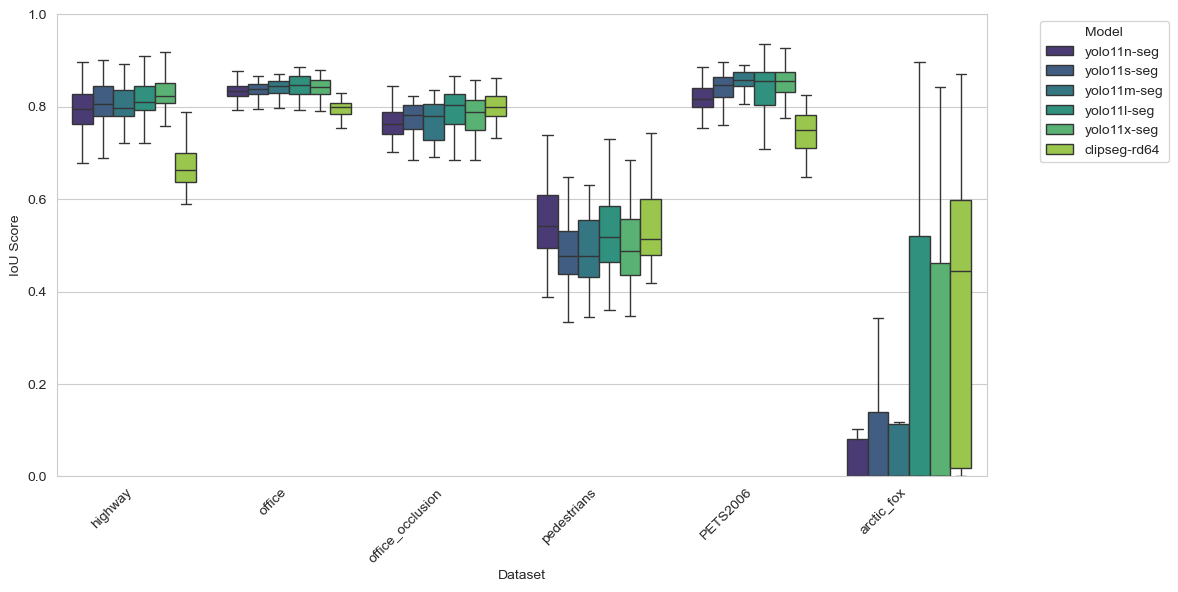

In [ ]:
# Plot des résultats des IoU pour chaque dataset pour chaque modèle
plot_model_compare(all_results, box_plot=True)

In [ ]:
# Permet d'obtenir un sous-ensemble des résultats
def slice_results(datasets:list[str], models:list[str], results):
    res = {}
    for model in models:
        model_sub_dir = {}
        for dataset in datasets:
            model_sub_dir[dataset] = results[model][dataset]
        res[model] = model_sub_dir
    return res

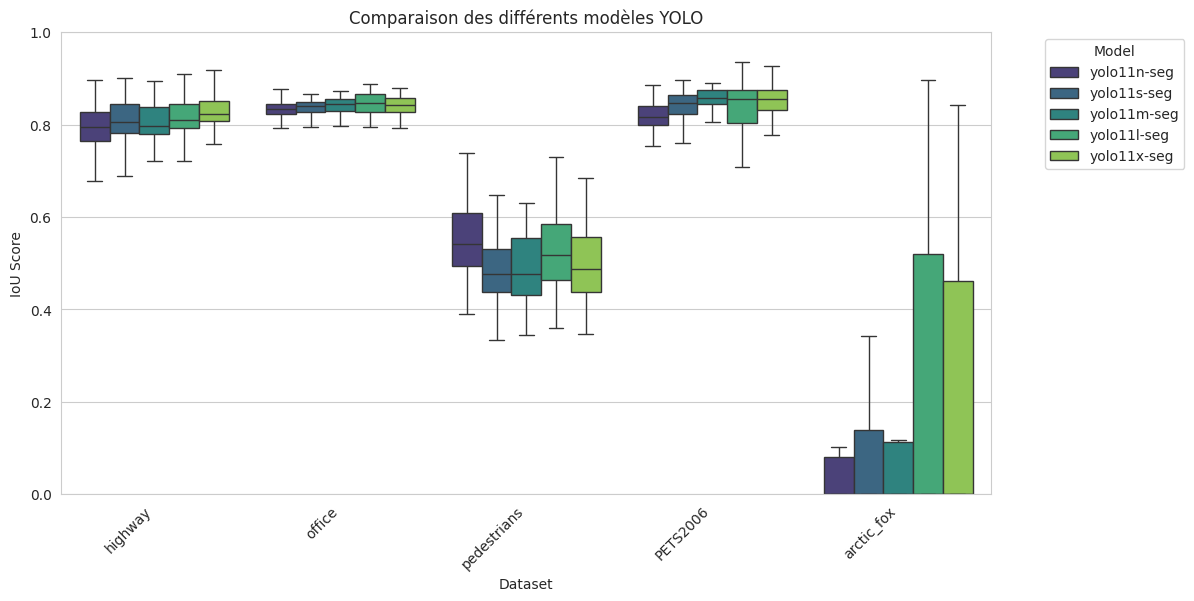

In [ ]:
# Comparaison des modèles YOLO
yolo_models = ["yolo11n-seg", "yolo11s-seg", "yolo11m-seg", "yolo11l-seg", "yolo11x-seg"]
yolo_datasets = ["highway", "office", "pedestrians", "PETS2006", "arctic_fox"]
yolo_slice = slice_results(yolo_datasets, yolo_models, all_results)

plot_model_compare(yolo_slice, box_plot=True, title="Comparaison des différents modèles YOLO")

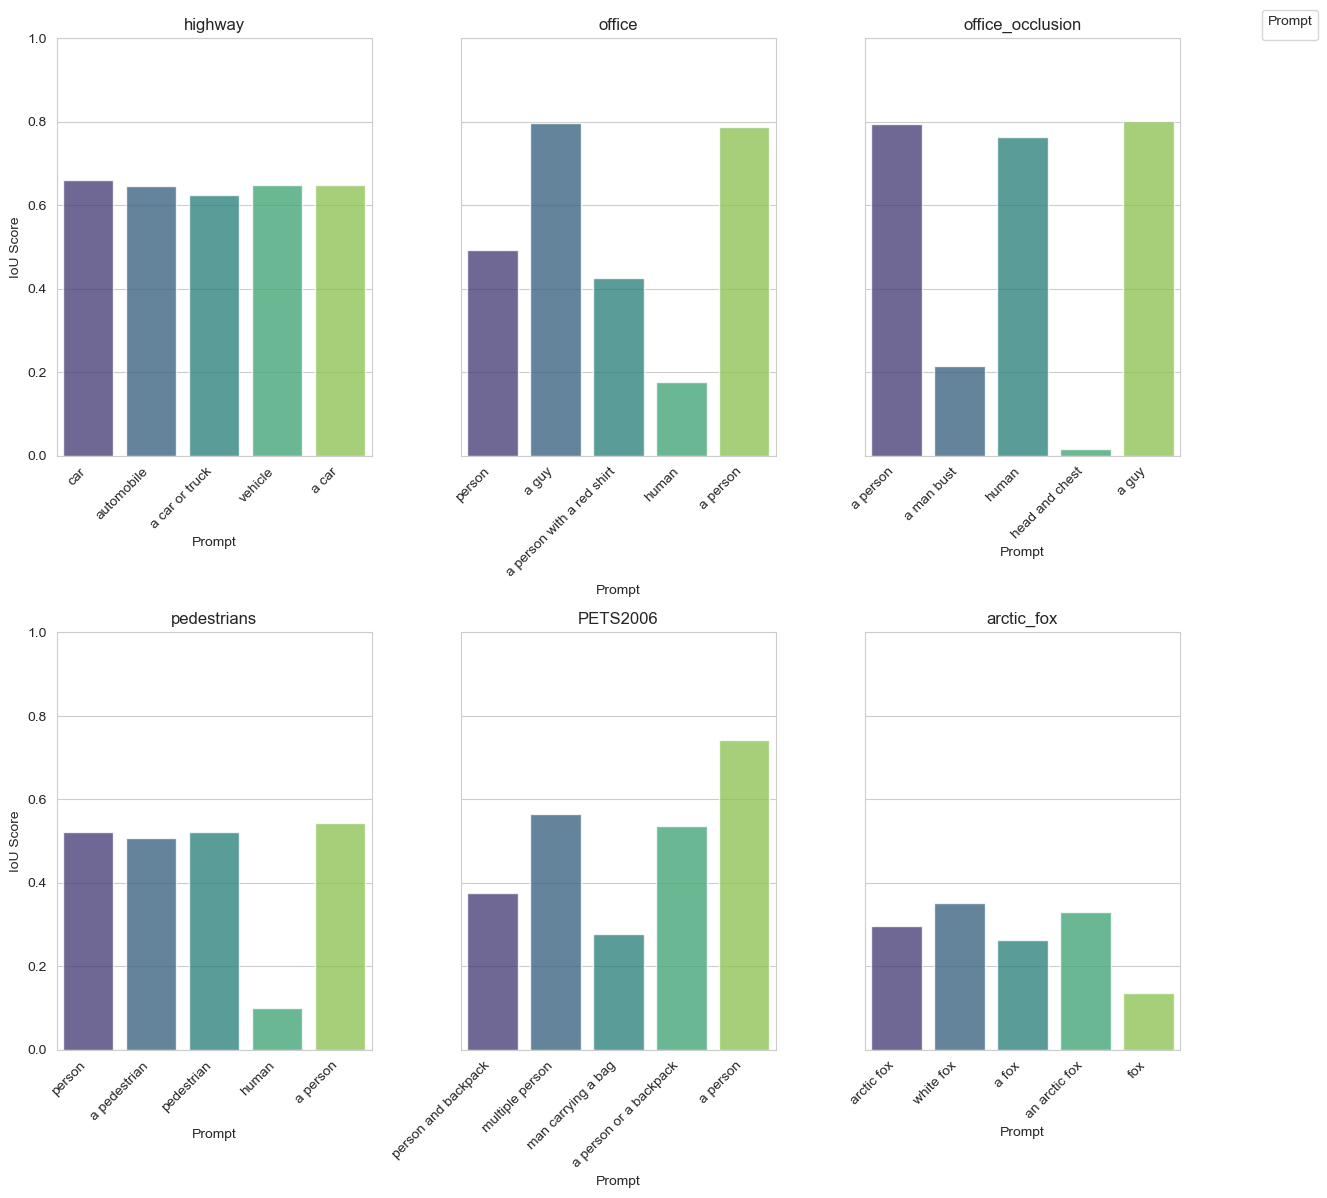

In [ ]:
# Comparaison des prompts pour chaque dataset pour CLIPSeg
plot_prompts_results(all_results["clipseg-rd64"])

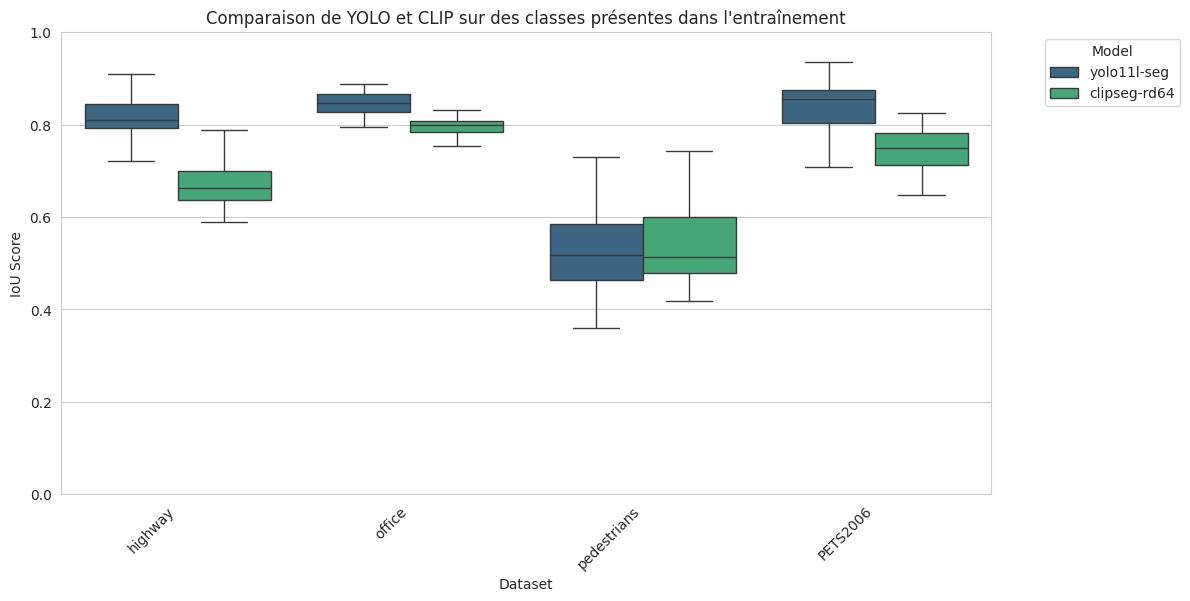

In [ ]:
# Comparaison des modèles YOLO et CLIPSeg sur des classes présentes dans l'entraînement
trained_models = ["yolo11l-seg", "clipseg-rd64"]
trained_datasets = ["highway", "office", "pedestrians", "PETS2006"]
trained_slice = slice_results(trained_datasets, trained_models, all_results)

plot_model_compare(trained_slice, box_plot=True, title="Comparaison de YOLO et CLIP sur des classes présentes dans l'entraînement")

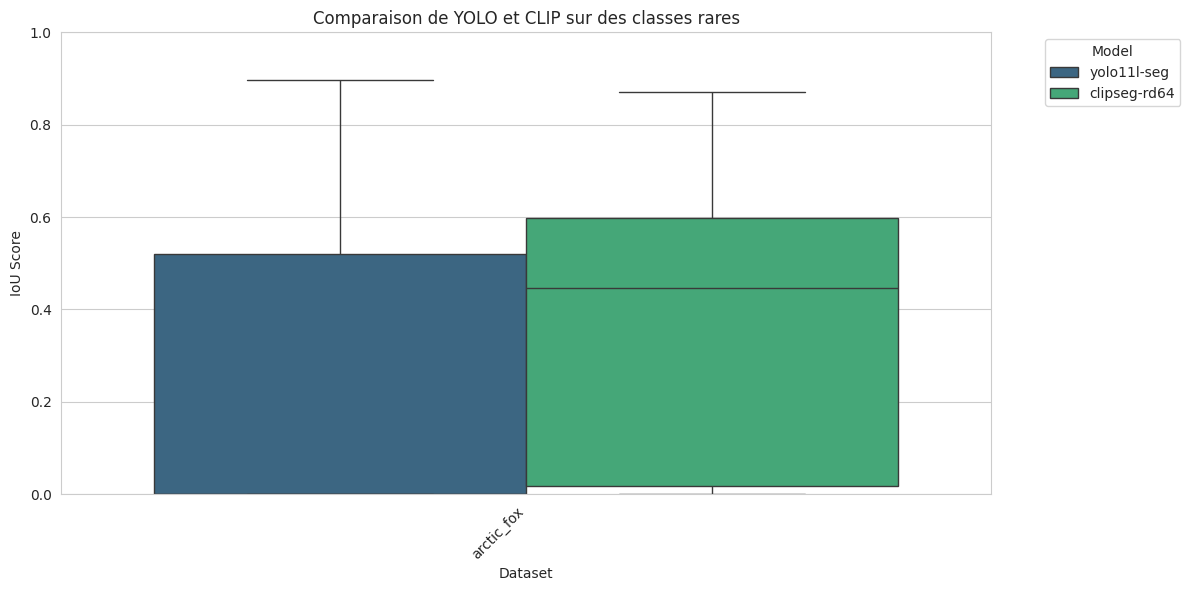

In [ ]:
# Comparaison des modèles YOLO et CLIPSeg sur des classes rares
rare_models = ["yolo11l-seg", "clipseg-rd64"]
rare_datasets = ["arctic_fox"]
rare_slice = slice_results(rare_datasets, rare_models, all_results)

plot_model_compare(rare_slice, box_plot=True, title="Comparaison de YOLO et CLIP sur des classes rares")

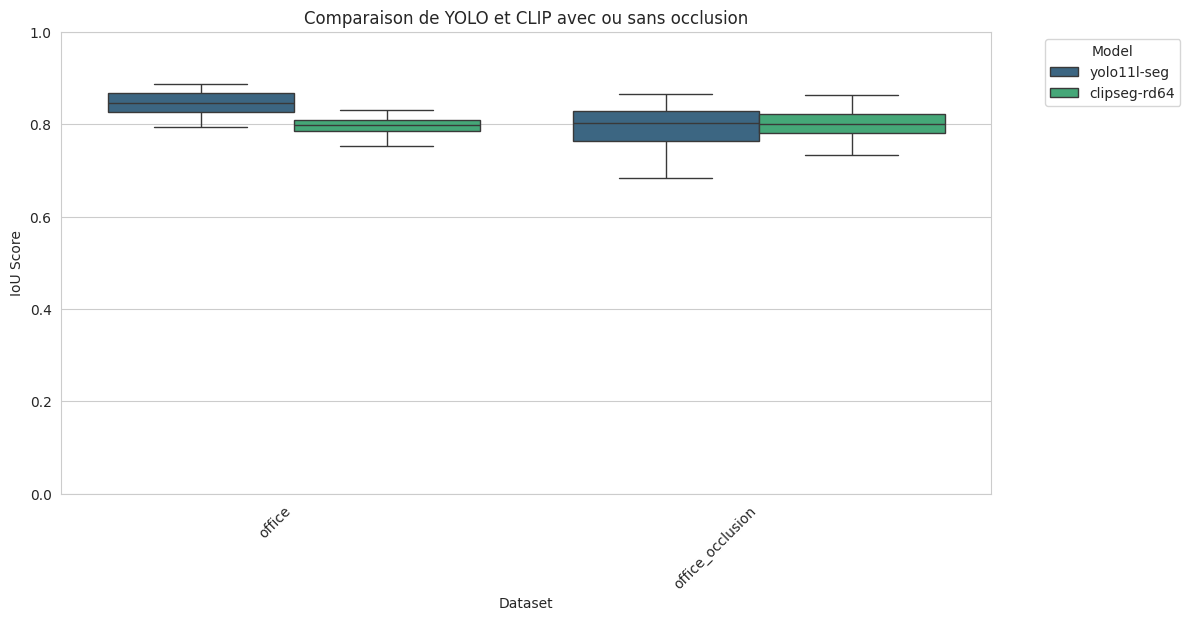

In [ ]:
# Comparaison des modèles YOLO et CLIPSeg avec ou sans occlusion
occlusion_models = ["yolo11l-seg", "clipseg-rd64"]
occlusion_datasets = ["office", "office_occlusion"]
occlusion_slice = slice_results(occlusion_datasets, occlusion_models, all_results)

plot_model_compare(occlusion_slice, box_plot=True, title="Comparaison de YOLO et CLIP avec ou sans occlusion")

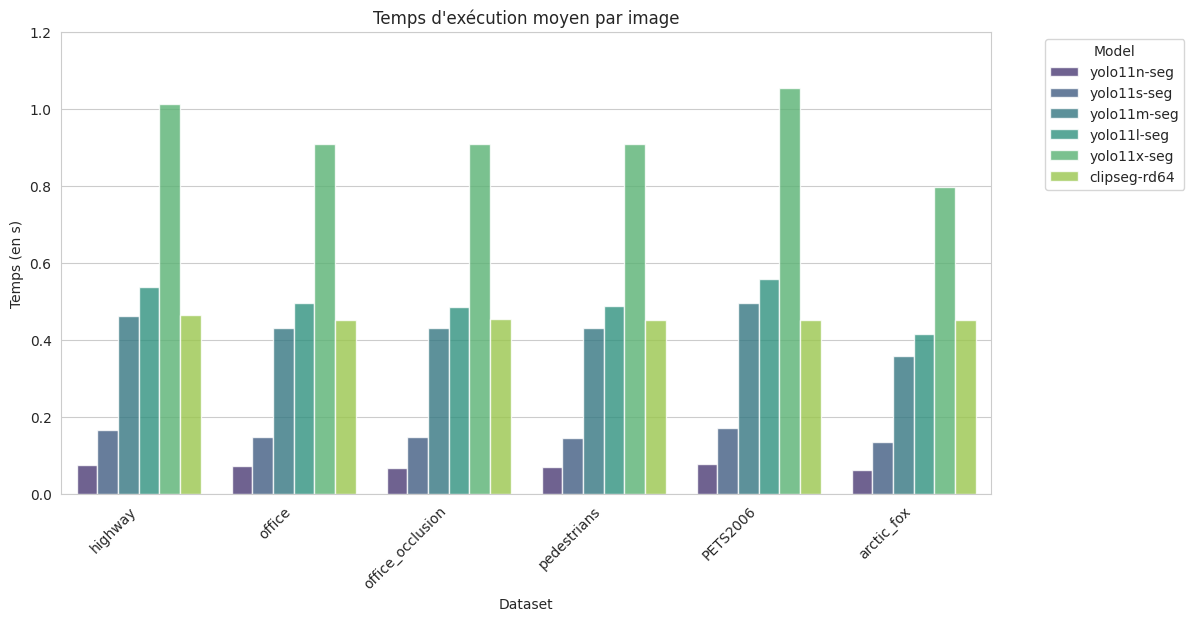

In [ ]:
# Comparaison des temps d'inférence pour chaque dataset pour chaque modèle
plot_time_compare(all_results, box_plot=False, title="Temps d'exécution moyen par image")

In [ ]:
# Temps d'inférence moyen par image pour chaque modèle
for model_name, model_data in all_results.items():
    for dataset, data in model_data.items():
        avg_time = max(data.values(), key=lambda x: x["avg_iou"])["avg_time"]
        print(f"{model_name} | {dataset}: {avg_time:.4f}s/image")

yolo11n-seg | highway: 0.0745s/image
yolo11n-seg | office: 0.0715s/image
yolo11n-seg | office_occlusion: 0.0659s/image
yolo11n-seg | pedestrians: 0.0685s/image
yolo11n-seg | PETS2006: 0.0769s/image
yolo11n-seg | arctic_fox: 0.0618s/image
yolo11s-seg | highway: 0.1647s/image
yolo11s-seg | office: 0.1467s/image
yolo11s-seg | office_occlusion: 0.1474s/image
yolo11s-seg | pedestrians: 0.1459s/image
yolo11s-seg | PETS2006: 0.1702s/image
yolo11s-seg | arctic_fox: 0.1342s/image
yolo11m-seg | highway: 0.4612s/image
yolo11m-seg | office: 0.4306s/image
yolo11m-seg | office_occlusion: 0.4304s/image
yolo11m-seg | pedestrians: 0.4319s/image
yolo11m-seg | PETS2006: 0.4949s/image
yolo11m-seg | arctic_fox: 0.3592s/image
yolo11l-seg | highway: 0.5361s/image
yolo11l-seg | office: 0.4966s/image
yolo11l-seg | office_occlusion: 0.4855s/image
yolo11l-seg | pedestrians: 0.4868s/image
yolo11l-seg | PETS2006: 0.5585s/image
yolo11l-seg | arctic_fox: 0.4143s/image
yolo11x-seg | highway: 1.0132s/image
yolo11x-seg

In [6]:
# IoU moyen pour chaque dataset pour chaque modèle
for model_name, model_data in all_results.items():
    for dataset, data in model_data.items():
        avg_iou = max(data.values(), key=lambda x: x["avg_iou"])["avg_iou"]
        print(f"{model_name} | {dataset}: {avg_iou:.4f}")

yolo11n-seg | highway: 0.7924
yolo11n-seg | office: 0.8337
yolo11n-seg | office_occlusion: 0.7411
yolo11n-seg | pedestrians: 0.5572
yolo11n-seg | PETS2006: 0.8185
yolo11n-seg | arctic_fox: 0.1175
yolo11s-seg | highway: 0.8055
yolo11s-seg | office: 0.8359
yolo11s-seg | office_occlusion: 0.7737
yolo11s-seg | pedestrians: 0.4828
yolo11s-seg | PETS2006: 0.8383
yolo11s-seg | arctic_fox: 0.1685
yolo11m-seg | highway: 0.8051
yolo11m-seg | office: 0.8405
yolo11m-seg | office_occlusion: 0.7494
yolo11m-seg | pedestrians: 0.4905
yolo11m-seg | PETS2006: 0.8556
yolo11m-seg | arctic_fox: 0.1582
yolo11l-seg | highway: 0.8202
yolo11l-seg | office: 0.8441
yolo11l-seg | office_occlusion: 0.7896
yolo11l-seg | pedestrians: 0.5284
yolo11l-seg | PETS2006: 0.8280
yolo11l-seg | arctic_fox: 0.2147
yolo11x-seg | highway: 0.8314
yolo11x-seg | office: 0.8419
yolo11x-seg | office_occlusion: 0.7777
yolo11x-seg | pedestrians: 0.5044
yolo11x-seg | PETS2006: 0.8514
yolo11x-seg | arctic_fox: 0.1828
clipseg-rd64 | highw